In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1727365732.5080476
Thu Sep 26 08:48:52 2024


In [2]:
from pennylane import broadcast
import torch
from torch.utils.data import DataLoader, TensorDataset


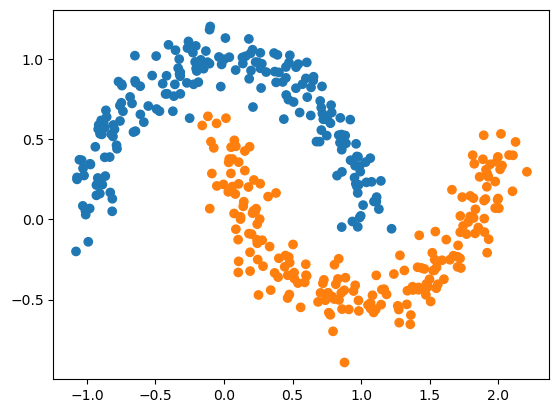

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

# Set random seeds
torch.manual_seed(149)
np.random.seed(149)

X, y = make_moons(n_samples=400, noise=0.1)
y_ = torch.unsqueeze(torch.tensor(y), 1)  # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((400, 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("on")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

In [4]:
N_train = 2000             # Number of training points
noise_0 = 0.001                            # Initial spread of random weight vector
N_test = 200                               # Number of test points
N_tot = N_train + N_test  

In [5]:
def twospirals(n_points, noise=0.7, turns=1.52, random_state=None):
        """Returns the two spirals dataset."""
       
        if random_state == None:
            rng_sp = np.random
        else:
            rng_sp = np.random.RandomState(random_state) 
        n = np.sqrt(rng_sp.rand(n_points, 1)) * turns * (2 * np.pi)
        d1x = -np.cos(n) * n + rng_sp.rand(n_points, 1) * noise
        d1y = np.sin(n) * n + rng_sp.rand(n_points, 1) * noise
        return (np.vstack((np.hstack((d1x,  d1y)),np.hstack((-d1x, -d1y)))), 
                np.hstack((np.zeros(n_points).astype(int),np.ones(n_points).astype(int))))

datasets = [twospirals(N_tot, random_state=21, turns=1.52),
            twospirals(N_tot, random_state=21, turns=2.0),
           ]

def digits2position(vec_of_digits, n_positions):
        """One-hot encoding of a batch of vectors. """
        return torch.tensor(np.eye(n_positions)[vec_of_digits])

def position2digit(exp_values):
        """Inverse of digits2position()."""
        return np.argmax(exp_values)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cm = plt.cm.RdBu                           # Test point colors
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Train point colors

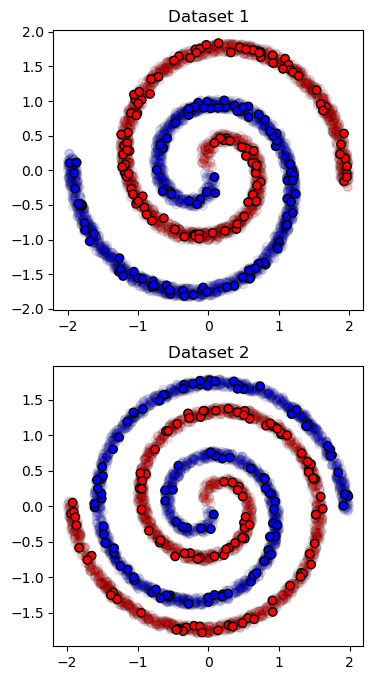

In [8]:
figure_dataset = plt.figure("dataset",figsize=(4, 4 * len(datasets)))
for ds_cnt, ds in enumerate(datasets):
        
        # Normalize dataset and split into training and test part
        X, y = ds
        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=N_test, random_state=42)
        
        # Plot the dataset
        ax = plt.subplot(len(datasets), 1, ds_cnt +1)
        ax.set_title("Dataset %d" % (ds_cnt+1))
        
        # Plot training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                edgecolors='k',alpha=0.1)
        
        # Plot test points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                edgecolors='k')

In [9]:
X_train

array([[ 0.96486612, -0.46504317],
       [-1.39912507, -1.23632414],
       [-0.92006257,  0.06370975],
       ...,
       [-0.58001106, -1.28967117],
       [-0.40112894,  1.68113069],
       [ 1.47197179,  0.51574187]])

In [10]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

In [11]:
import pennylane as qml

n_qubits = 10
dev = qml.device("default.qubit", wires=n_qubits)

def H_layer(n_qubits):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

def custom_rot_layer(weights, wires):
    for i, wire in enumerate(wires):
        phi, theta, omega = weights[i]
        qml.Rot(phi, theta, omega, wires=wire)

def entangling_layer(wires, measured_1, measured_2):
    for j in range(len(wires) - 1):
        qml.CNOT(wires=[wires[j], wires[j + 1]])
        qml.cond(measured_1, qml.CRZ)(np.pi / 2, wires=[wires[j], wires[j + 1]])
        qml.cond(measured_2, qml.CRY)(np.pi / 4, wires=[wires[j], wires[j + 1]])

@qml.qnode(dev)
def qnode(inputs, weights, x, z):
    H_layer(n_qubits)

    for i in range(n_layers):
        if i % 2 == 0:
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        else:
            qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Z')
        
        measured_1 = qml.measure(1)
        measured_2 = qml.measure(2)
        entangling_layer(range(n_qubits), measured_1, measured_2)
        custom_rot_layer(weights[i], range(n_qubits))

    custom_rot_layer(weights[-1], range(n_qubits))
    qml.cond(measured_2, qml.CRZ)(z, wires=(3, 0))
    H_layer(n_qubits)

    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)], qml.probs(op=measured_2)

In [12]:
n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}

In [14]:
print(qml.draw(qnode, expansion_strategy="device")(w,w))

0: ──H──RY(M0)──RZ(M0)──RY(M0)──RY(M0)──RZ(M0)──RY(M0)──H──RY(0.26)──RY(0.64)──RY(0.89)──RY(0.52)
1: ──H──RY(M1)──RZ(M1)──RY(M1)──RY(M1)──RZ(M1)──RY(M1)──H──RY(0.51)──RY(0.04)──RY(0.88)──RY(0.33)
2: ──H──RY(M2)──RZ(M2)──RY(M2)──RY(M2)──RZ(M2)──RY(M2)──H──RY(0.03)──RY(0.59)──RY(0.04)──RY(0.62)
3: ──H──RY(M3)──RZ(M3)──RY(M3)──RY(M3)──RZ(M3)──RY(M3)──H──RY(0.32)──RY(0.16)──RY(0.90)──RY(0.51)
4: ──H──RY(M4)──RZ(M4)──RY(M4)──RY(M4)──RZ(M4)──RY(M4)──H──RY(0.37)──RY(0.84)──RY(0.97)──RY(0.60)
5: ──H──RY(M5)──RZ(M5)──RY(M5)──RY(M5)──RZ(M5)──RY(M5)──H──RY(0.44)──RY(0.54)──RY(0.92)──RY(0.16)
6: ──H──RY(M6)──RZ(M6)──RY(M6)──RY(M6)──RZ(M6)──RY(M6)──H──RY(0.28)──RY(0.69)──RY(0.17)──RY(0.99)
7: ──H──RY(M7)──RZ(M7)──RY(M7)──RY(M7)──RZ(M7)──RY(M7)──H──RY(0.98)──RY(0.64)──RY(0.04)──────────
8: ──H──RY(M8)──RZ(M8)──RY(M8)──RY(M8)──RZ(M8)──RY(M8)──H──RY(0.57)──RY(0.94)──RY(0.25)──RY(0.84)
9: ──H──RY(M9)──RZ(M9)──RY(M9)──RY(M9)──RZ(M9)──RY(M9)──H──RY(0.40)──RY(0.54)──RY(0.78)──RY(0.35)

───────────────────

/global/homes/g/gzquse/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/pennylane/drawer/draw.py:37: PennyLaneDeprecationWarning: The 'expansion_strategy' argument is deprecated and will be removed in version 0.39. Instead, use the 'level' argument which offers more flexibility and options.
  warnings.warn(


In [15]:
loss_func = torch.nn.L1Loss()

In [16]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 20)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(20, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 10, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
from matplotlib.colors import ListedColormap
h=0.2
cm = plt.cm.RdBu                           # Test point colors
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # Train point colors

In [ ]:
figure_main = plt.figure("main",figsize=(4 * (2 + 1), 4 * 2))
#X = torch.tensor(X, requires_grad=True).float()
#X = X.detach().numpy()

y_hot = y_hot.float()

batch_size = 5
batches = 200 // batch_size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=149)
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, requires_grad=True).float()
y_train_hot = digits2position(y_train, 2)

X_test = torch.tensor(X_test, requires_grad=True).float()
y_test_hot = digits2position(y_test, 2)

# plot settings
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

train_dataset = TensorDataset(X_train, y_train_hot)
test_dataset = TensorDataset(X_test, y_test_hot)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=True, drop_last=True)

X_train = X_train.detach().numpy()
X_test = X_test.detach().numpy()

# plot the training dataset
ax = plt.subplot(2, 2 + 1, 1)
# plot training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        edgecolors='k', alpha=0.1)

# Plot test points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
        edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

opt = torch.optim.Adam(model.parameters(), lr=0.0004)

train_acc_history = []
test_acc_history = []

# iterate
grid_points = np.c_[xx.ravel(), yy.ravel()]

epochs = 100

for epoch in range(epochs):
    train_running_loss = 0
    test_running_loss = 0
    for xs, ys in train_loader:
        opt.zero_grad()

        loss_evaluated = loss_func(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        train_running_loss += loss_evaluated.item()
        
    train_avg_loss = train_running_loss / batches

    print(f"Train - Epoch {epoch + 1}: Loss: {train_avg_loss:.4f}")
    
    X_train = torch.tensor(X_train, requires_grad=True).float()
    # Calculate train accuracy
    y_pred_train = model(X_train)
    predictions_train = torch.argmax(y_pred_train, axis=1).detach().numpy()

    correct_train = [1 if p == p_true else 0 for p, p_true in zip(predictions_train, y_train)]
    train_accuracy = sum(correct_train) / len(correct_train)
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
    train_acc_history.append(train_accuracy)
    
    # Calculate testmodel.eval()
    with torch.no_grad():
        X_test = torch.tensor(X_test, requires_grad=True).float()
        y_pred_test = model(X_test)
        predictions_test = torch.argmax(y_pred_test, axis=1).detach().numpy()
        correct_test = [1 if p == p_true else 0 for p, p_true in zip(predictions_test, y_test)]
        test_accuracy = sum(correct_test) / len(correct_test)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        test_acc_history.append(test_accuracy)
        
    # In order to draw the decision border we 
    # compute predictions for the whole 2D plane.

    grid_points = torch.tensor(grid_points, requires_grad=True).float()
    grid_results = model(grid_points).detach().numpy()
    Z = np.tanh(grid_results[:, 1] - grid_results[:, 0])
    Z = Z.reshape(xx.shape)

    # Add subplot to the main figure.
    ax = plt.subplot(2, 2 + 1, 2)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    X_train = X_train.detach().numpy()
    X_test = X_test.detach().numpy()
    # Plot training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
            edgecolors='k', alpha=0.1)
    
    # Plot test points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
            edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

Train - Epoch 1: Loss: 7.3779
Train Accuracy: 59.87%
Test Accuracy: 60.45%
Train - Epoch 2: Loss: 6.6156
Train Accuracy: 62.82%
Test Accuracy: 62.27%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 3: Loss: 6.2913
Train Accuracy: 63.41%
Test Accuracy: 63.11%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 4: Loss: 6.0425
Train Accuracy: 65.00%
Test Accuracy: 65.08%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 5: Loss: 5.6826
Train Accuracy: 73.21%
Test Accuracy: 72.05%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 6: Loss: 5.2000
Train Accuracy: 77.79%
Test Accuracy: 77.80%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 7: Loss: 4.7915
Train Accuracy: 79.77%
Test Accuracy: 79.39%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 8: Loss: 4.4527
Train Accuracy: 80.13%
Test Accuracy: 80.38%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 9: Loss: 4.1525
Train Accuracy: 83.25%
Test Accuracy: 82.58%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 10: Loss: 3.8577
Train Accuracy: 84.12%
Test Accuracy: 83.41%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 11: Loss: 3.5784
Train Accuracy: 86.23%
Test Accuracy: 85.53%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 12: Loss: 3.2840
Train Accuracy: 88.67%
Test Accuracy: 88.71%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 13: Loss: 3.0616
Train Accuracy: 89.32%
Test Accuracy: 89.39%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 14: Loss: 2.8762
Train Accuracy: 89.45%
Test Accuracy: 89.77%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 15: Loss: 2.7149
Train Accuracy: 89.84%
Test Accuracy: 90.23%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 16: Loss: 2.5670
Train Accuracy: 90.49%
Test Accuracy: 90.83%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 17: Loss: 2.4225
Train Accuracy: 91.27%
Test Accuracy: 91.67%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 18: Loss: 2.2629
Train Accuracy: 92.27%
Test Accuracy: 92.73%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 19: Loss: 2.0945
Train Accuracy: 92.99%
Test Accuracy: 93.11%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 20: Loss: 1.9283
Train Accuracy: 94.03%
Test Accuracy: 95.08%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 21: Loss: 1.7101
Train Accuracy: 96.01%
Test Accuracy: 96.06%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 22: Loss: 1.5635
Train Accuracy: 96.07%
Test Accuracy: 95.98%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 23: Loss: 1.4641
Train Accuracy: 95.97%
Test Accuracy: 95.83%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 24: Loss: 1.3797
Train Accuracy: 96.07%
Test Accuracy: 96.06%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 25: Loss: 1.3079
Train Accuracy: 96.07%
Test Accuracy: 96.06%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 26: Loss: 1.2432
Train Accuracy: 96.07%
Test Accuracy: 96.06%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 27: Loss: 1.1850
Train Accuracy: 95.97%
Test Accuracy: 95.98%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 28: Loss: 1.1347
Train Accuracy: 96.14%
Test Accuracy: 96.06%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 29: Loss: 1.0913
Train Accuracy: 96.14%
Test Accuracy: 96.06%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 30: Loss: 1.0498
Train Accuracy: 96.23%
Test Accuracy: 96.14%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 31: Loss: 1.0095
Train Accuracy: 96.33%
Test Accuracy: 96.29%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 32: Loss: 0.9706
Train Accuracy: 96.17%
Test Accuracy: 96.14%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 33: Loss: 0.9426
Train Accuracy: 96.23%
Test Accuracy: 96.21%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 34: Loss: 0.9146
Train Accuracy: 96.23%
Test Accuracy: 96.21%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 35: Loss: 0.8828
Train Accuracy: 96.43%
Test Accuracy: 96.36%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 36: Loss: 0.8613
Train Accuracy: 96.43%
Test Accuracy: 96.44%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 37: Loss: 0.8383
Train Accuracy: 96.43%
Test Accuracy: 96.36%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 38: Loss: 0.8171
Train Accuracy: 96.56%
Test Accuracy: 96.44%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 39: Loss: 0.7990
Train Accuracy: 96.53%
Test Accuracy: 96.44%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 40: Loss: 0.7799
Train Accuracy: 96.53%
Test Accuracy: 96.44%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 41: Loss: 0.7640
Train Accuracy: 96.43%
Test Accuracy: 96.44%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 42: Loss: 0.7481
Train Accuracy: 96.53%
Test Accuracy: 96.44%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 43: Loss: 0.7317
Train Accuracy: 96.56%
Test Accuracy: 96.52%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 44: Loss: 0.7189
Train Accuracy: 96.56%
Test Accuracy: 96.44%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 45: Loss: 0.7051
Train Accuracy: 96.53%
Test Accuracy: 96.44%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


Train - Epoch 46: Loss: 0.6944
Train Accuracy: 96.62%
Test Accuracy: 96.52%


/tmp/ipykernel_1014499/2985436445.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid_points = torch.tensor(grid_points, requires_grad=True).float()


In [ ]:
# Plotting the training and testing accuracies
ax = plt.subplot(111)
ax.plot(train_acc_history, linestyle='-', marker='^', label='Train Accuracy', color='C1')
ax.plot(test_acc_history, linestyle='--', marker='o', label='Test Accuracy', color='C2')
ax.set(title='Training and Testing Accuracy over Epochs', xlabel='Epoch', ylabel='Accuracy')
# ax.set_yscale('log')
# Limit Y-axis and X-axis
ax.set_ylim(0.85, 1.01)
ax.set_xlim(0, 100)
ax.grid()
ax.legend(bbox_to_anchor=(0.65,0.75), fontsize=8.5)
ax.axhline(1, ls='--', lw=2, c='m')
ax.text(35, 0.98, '100% train accuracy', c='m')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

# Create the inset of zoomed-out view
axins = inset_axes(ax, width="30%", height="30%", loc="lower right", borderpad=3)

# Plot the zoomed-out view on the inset
axins.plot(train_acc_history, linestyle='-', marker='^', color='C1')
axins.plot(test_acc_history, linestyle='--', marker='o', color='C2')

# Set limits for the inset (zoomed-out view)
axins.set_xlim(0, len(train_acc_history))
axins.set_ylim(0.85, 1.01)

# Add gridlines and remove ticks to make the inset cleaner
axins.grid(False)
axins.tick_params(left=False, bottom=False)  # Optional: remove ticks on the inset

plt.savefig('plt2.png')
plt.show()